In [1]:
import numpy as np

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Chỉ quan tâm tới các key:
- 'data': show data thực sự của dataset (các pixel, tổng cộng có 28x28 pixels)
- 'target': cột target cần dự đoán (số mấy)

In [3]:
X, y = mnist['data'], mnist['target']
X.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
X.shape

(70000, 784)

In [33]:
X.dtypes

pixel1      float64
pixel2      float64
pixel3      float64
pixel4      float64
pixel5      float64
             ...   
pixel780    float64
pixel781    float64
pixel782    float64
pixel783    float64
pixel784    float64
Length: 784, dtype: object

In [5]:
y.unique()

['5', '0', '4', '1', '9', '2', '3', '6', '7', '8']
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']

cột target đang có kiểu category ko phù hợp, cần đổi sang kiểu int

In [6]:
y = y.astype(np.uint8)
y.unique()

array([5, 0, 4, 1, 9, 2, 3, 6, 7, 8], dtype=uint8)

Visualize số đầu tiên
- Đầu tiên chuyển về dạng shape 28x28
- vẽ **ảnh** của số đầu tiên, thông qua `plt.imshow`, với cmap có dạng: mpl.cm.màu_phù_hợp, với màu_phù_hợp dc chọn từ link: https://matplotlib.org/stable/gallery/color/colormap_reference.html 

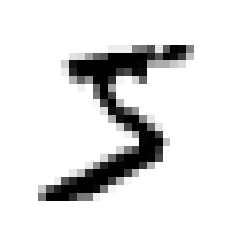

In [7]:
import matplotlib as mpl # dùng cmap mpl.cm.màu
import matplotlib.pyplot as plt

first_digit = X.loc[0].values # lấy numpy array
first_digit_img = first_digit.reshape(28, 28) # reshape lại mới vẽ dc ảnh 28x28
plt.imshow(first_digit_img, cmap= mpl.cm.binary) # ra gần giống số 5
plt.axis('off'); # bỏ đi trục

## Tách tập train & tập test
tập MNIST có sẵn trong thư viện đã chia sẵn 60000 dòng đầu là X_train, 10000 dòng cuối là X_test 

In [8]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Phân bố các class trong y_train như thế nào?

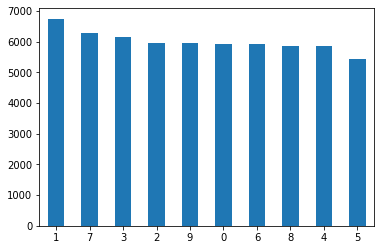

In [9]:
y_train.value_counts().plot.bar(rot=0);

Nhận xét: phân bố tương đối đều

# I. Training a binary classifier

Ở phần này sẽ sử dụng 2 classifier: `SGDClassifier` & `RandomForestClassifier`, sau đó dùng các độ do: `precision/recall`, `ROC curve`

- Đầu tiên, ta sẽ train cho classifier để nhận biết số 5 (true) và non-5 (false) -> theo đúng tinh thần binary

In [10]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

## 1. Classifier: Stochastic Gradient Descent (SGD)

In [11]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [12]:
sgd_clf.predict([first_digit])

array([ True])

-> Như đã nói, True là số 5 (dự đoán đúng). 

Bây giờ ta sẽ dự đoán trên toàn bộ tập train, thay vì gọi method `.predict()` thì sẽ gọi hàm `cross_val_predict()` (Why?? - vì ta sẽ tận dụng tham số `method` sau này để set `decision_function`). Chia tập train thành cv=3 tập nhỏ, mỗi lần lặp thì gọi hàm fit() trên 2 tập (coi là 2 tập train) và gọi predict() trên tập còn lại (coi là 1 tập test)

In [13]:
from sklearn.model_selection import cross_val_predict
y_train_5_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
y_train_5_pred

array([ True, False, False, ...,  True, False, False])

### a) Confusion matrix

**warning**: Coi nhanh confusion matrix để biết cách dùng, ko quan trọng lắm

In [14]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_5_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

confusion matrix theo thứ tự sau:
|   | -  | +  |
|---|----|----|
| - | TN | FP |
| + | FN | TP |

### b) precision/recall tradeoff

In [15]:
from sklearn.metrics import precision_score, recall_score

print(f'precision: {precision_score(y_train_5, y_train_5_pred)}')
print(f'recall: {recall_score(y_train_5, y_train_5_pred)}')

precision: 0.8370879772350012
recall: 0.6511713705958311


Nhận xét: 
- precision: khi model dự đoán 1 ảnh là số 5, thì xác suất dự đoán đúng là 83.71%
- recall: model chỉ detect dc 65.12% số số 5

-> đánh giá: mô hình dự đoán số 5 chưa đủ tốt

#### Chọn threshold để tăng precision/recall hoặc ít nhất là có precision và recall cao vừa đủ

- Đầu tiên, cần get score (score này lúc sau dẽ dc so sánh với threshold) của tất cả instance trong `X_train`. Để làm dc chuyện đó thì cần specify method="decision_function" trong hàm `cross_val_predict`, đại khái hàm decision function là hàm tính ra score của 1 instance, ko phải true/false như predict() vì ta đang cần là score để so sánh vs threshold
- More on decision function & score: https://www.geeksforgeeks.org/ml-decision-function/ 

In [16]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

- Tiếp theo, vẽ đường cong precision/recall để xác định threshold cần lấy nên là bao nhiêu. Ở đây, ta dùng `precision_recall_curve()` để tính chỉ số precision và recall theo từng threshold trong mảng `thresholds` (VD: với `thresholds`[0]= 1000 thì `precisions`[0] = 90% và `recall`[0] = 80%)
- Lưu ý: `thresholds` hàm sẽ tự tính và cho mình 1 số giá trị
- Gs trong project này ta cần 90% precision (thà đoán ít mà đoán đúng còn hơn là bỏ sót)

In [17]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [18]:
# cell này để coi output 3 giá trị precisions, recalls, thresholds ở trên
thresholds

array([-106527.45300471, -105763.22240074, -105406.2965229 , ...,
         38871.26391927,   42216.05562787,   49441.43765905])

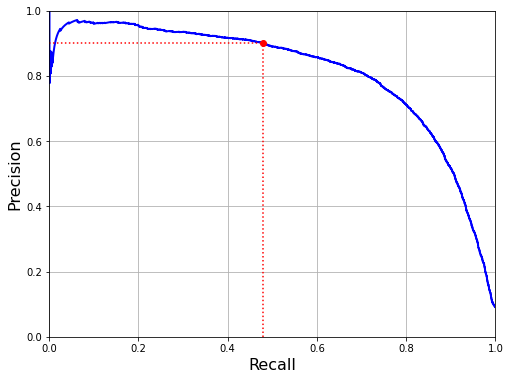

In [19]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

# aim for 90% precision
recall_90_precision = recalls[np.argmax(precisions >= 0.90)] # lấy recall mà tại đó precision đạt ít nhất 90% (index đầu tiên)
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0, 0.9], "r:") # vẻ đường dọc
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:") # vẽ đường ngang
plt.plot([recall_90_precision], [0.9], "ro") # chấm đỏ

Như vậy threshold cần tìm là:

In [20]:
threshold_90_precision

3370.019499143958

- Bây giờ ta dự đoán lại để coi precision và recall thay đổi thế nào. Để làm dc điều này thì tận dụng threshold (đã có) và score của từng instance xác định bởi decision function (đã có)

In [21]:
y_train_5_pred_90 = (y_scores >= threshold_90_precision)
# check precision/recall
print(f'precision: {precision_score(y_train_5, y_train_5_pred_90)}')
print(f'recall: {recall_score(y_train_5, y_train_5_pred_90)}')

precision: 0.9000345901072293
recall: 0.4799852425751706


Nhận xét: precision > recall -> thà đoán ít mà đoán đúng còn hơn là bỏ sót

### c) ROC curve

In [22]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores) # y_scores vẫn là của sgd model

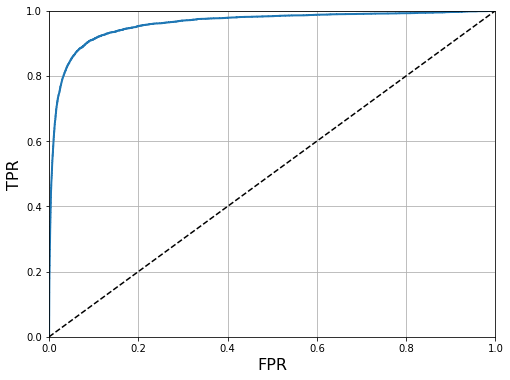

In [23]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label) # ROC curve
    plt.plot([0, 1], [0, 1], 'k--') # vẽ đường chéo
    plt.axis([0, 1, 0, 1])  # plt.axis([xmin, xmax, ymin, ymax])                                  
    plt.xlabel('FPR', fontsize=16) 
    plt.ylabel('TPR', fontsize=16)    
    plt.grid(True)                                            

plt.figure(figsize=(8, 6))                                    
plot_roc_curve(fpr, tpr)               

- Tính AUC cho đường ROC curve của `sdg_clf`

In [24]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

## 2. Classifier: Random Forest

- <font color='red'>Lưu ý</font>: random forest ko có **decision function** như sgd nên ko tính **score** trực tiếp dc. Thay vào đó có thể tính gián tiếp qua `method='predict_proba'` trong hàm `cross_val_predict` rồi lấy score chính là **positive class’s probability**

In [25]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")
y_probas_forest

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       ...,
       [0.02, 0.98],
       [0.92, 0.08],
       [0.94, 0.06]])

Output có shape là (60000, 2) với 60000 dòng (chính là 60000 instance trong dataset), 2 là 2 xác suất mà instance thuộc về (negatve class's probability và positive class's probability). instance thuộc về class nào hơn sẽ có xác suất cao hơn

In [26]:
y_scores_forest = y_probas_forest[:, 1] 
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

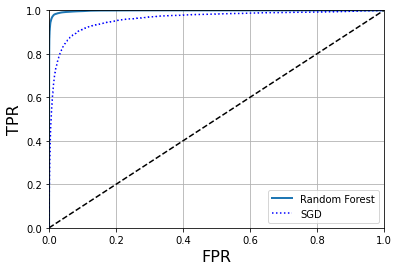

In [27]:
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot(fpr, tpr, "b:", label="SGD")
plt.legend(loc="lower right")
# plt.show()

Nhận xét: về mặt cảm quan, rõ ràng Random Forest tốt hơn SGD (do nằm xa đường chéo về phía top-left hơn). Ta sẽ thể hiện điều đó bằng AUC của random forest

In [28]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

-> Quả tốt hơn thật :D

# II. Training multiclass classifiers

## 1. Chiến lược OvA
- Hầu hết Scikit classifier (trừ SVM là OvO) đều mặc định sử dụng OvA ở bên dưới. Ví dụ cho `sgd_clf`

In [29]:
sgd_clf.fit(X_train, y_train) # y_train, not y_train_5
sgd_clf.predict([first_digit]) # using OvA 

array([3], dtype=uint8)

In [30]:
y_train[0]

5

Nhận xét: dự đoán sai

Scikit classifier store target classes trong thuộc tính `classes_`, trong TH này, `classes_` chứa 10 số từ 0 - 9

In [36]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

- Hmmm, thử đo performance của `sgd_clf` bằng `cross_val_score()`

In [37]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

Nhận xét: >85% - cũng tạm ổn. Ta thử scale tất cả pixel về cùng 1 độ đo xem có tăng accuracy ko

In [38]:
from sklearn.preprocessing import StandardScaler
    
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

Nhận xét: >89% -> cũng cải thiện dc chút

## 2. Chiến lược OvO
- Ta có thể thay đổi mặc định OvA của Scikit classifier thành OvO nhờ `OneVsOneClassifier` constructor. Chỉ cần pass classifier muốn dùng OvO vào constructor rồi gọi như bên dưới là ok

In [32]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42)) # ép SGDClassifier thành OneVsOneClassifier
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([first_digit])

array([5], dtype=uint8)

Nhận xét: dự đoán đúng

## 3. Chiến lược trực tiếp từ thuật toán Random Forest

In [34]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([first_digit])

array([5], dtype=uint8)

Nhận xét: dự đoán đúng

## 4. Error Analysis

- Đến dc mục 4 này yêu cầu ta đã tìm ra model phù hợp nhất sau khi thử nhiều model (Gs trong TH này là `sgd_clf`). Sau đó quan sát lỗi confused gây ra bởi model và đánh giá + đưa ra chiến lược cải thiện model ấy

In [39]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

Nhận xét:
- np array có kích thước 10x10, 10 hàng actual class (0-9), và 10 cột predicted class
- nhìn hơi khó, ta sẽ thể hiện lại bằng ma trận màu sắc

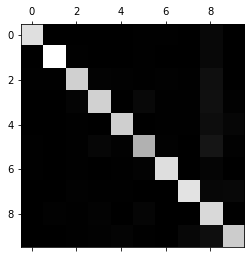

In [40]:
plt.matshow(conf_mx, cmap=plt.cm.gray)

Nhận xét: 
- Đa phần các class dc phân loại đúng (đường chéo trái khá trắng/lớn)
- Số 5 hơi tối màu hơn. Lý do có thể là số số 5 ít hơn so với các số khác (quả thật - coi lại phần đầu) hoặc clf ko perform tốt trên số 5
- Cột số 8 có vẻ có nhiều ô trắng (mờ), có thể nhiều số khác dễ bị phân loại sai thành số 8

Bây giờ ta sẽ plot ma trận 'độ lỗi', chỗ nào sáng thì chỗ đó lỗi nhiều. Đạt dc điều này bằng cách chia mỗi gtri trong hàng của confusion_mx cho tổng từng hàng của label đó

In [49]:
row_sums = conf_mx.sum(axis=1) # tổng từng hàng
norm_conf_mx = conf_mx / row_sums
# norm_conf_mx

Tiếp theo, điền số 0 cho đường chéo, mục đích là để giữ lại `error rates`, còn đường chéo = dự đoán đúng thì error rate = 0. Nếu ko làm vậy thì ma trận màu của norm_conf_mx ko khác gì `conf_mx` và màu trắng nó át đi những màu trắng nhạt rất nhiều

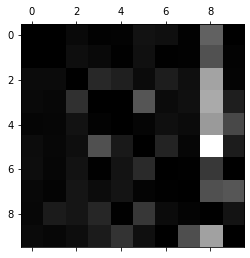

In [43]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)

Nhận xét:
- Đúng như dự đoán, rất nhiều số bị dự đoán sai thành số 8 (cột 8 khá sáng). Giải pháp:
    - Cần reduce false 8s bằng cách thu thập thêm dữ liệu về digits viết hơi giống số 8 nhưng ko phải là số 8 (VD: số 5)
    - Tạo thuộc tính mới. VD viết thuật toán đếm số 'bụng' của digit (số 8 thì có 2 bụng, số 6 có 1 bụng, số 5 ko có bụng nào)
- Số 3 & 5 củng hay bị nhầm lẫn

# III. Exercises

## 1. An MNIST Classifier With >97% Accuracy
Hint: The `KNeighborsClassifier` works quite well for this task

In [52]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

param_grid = {'n_neighbors': [3,4,5], 'weights': ["uniform", "distance"]}
knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid) 
grid_search.fit(X_train, y_train) # >10 hr to run

In [ ]:
grid_search.best_params_

In [ ]:
from sklearn.metrics import accuracy_score

y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)